# Analyze coexpression QTL

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm
import imp
pd.set_option('display.max_columns', 100)
import os
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import run_memento

In [3]:
data_path  = '/data_volume/memento/lupus/'

### Read all coex results

In [4]:
cqtls = []
all_tests = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}_coexpression.csv'.format(pop, ct))
        df['pop'] = pop
        df['ct'] = ct
        if df.query('corr_fdr < 0.1').shape[0] > 0:
            cqtls.append(df.query('corr_fdr < 0.1'))
            print(pop, ct, df.query('corr_fdr < 0.1')[['gene_1', 'gene_2']].drop_duplicates().shape[0])
        all_tests.append(df)
cqtls = pd.concat(cqtls)
all_tests = pd.concat(all_tests)

asian T4 6
asian cM 48
asian ncM 121
asian T8 18
eur cM 31
eur ncM 8
eur T8 5
eur B 23


In [5]:
all_tests = all_tests.dropna()

(array([128298., 103004.,  96128.,  95121.,  94606.,  93361.,  91613.,
         92236.,  88165.,  86525.,  89078.,  84943.,  85856.,  85979.,
         86120.,  84191.,  85911.,  86750.,  86286.,  84688.,  83523.,
         82927.,  83515.,  85171.,  84009.,  84557.,  84144.,  81320.,
         83458.,  82460.,  82380.,  81074.,  80779.,  82854.,  83304.,
         81292.,  80547.,  81097.,  80704.,  79319.,  81973.,  80475.,
         79822.,  81747.,  80845.,  81984.,  82377.,  79568.,  81588.,
         81967.]),
 array([2.66217104e-17, 1.99999907e-02, 3.99999814e-02, 5.99999721e-02,
        7.99999629e-02, 9.99999536e-02, 1.19999944e-01, 1.39999935e-01,
        1.59999926e-01, 1.79999916e-01, 1.99999907e-01, 2.19999898e-01,
        2.39999889e-01, 2.59999879e-01, 2.79999870e-01, 2.99999861e-01,
        3.19999851e-01, 3.39999842e-01, 3.59999833e-01, 3.79999824e-01,
        3.99999814e-01, 4.19999805e-01, 4.39999796e-01, 4.59999786e-01,
        4.79999777e-01, 4.99999768e-01, 5.19999759e-

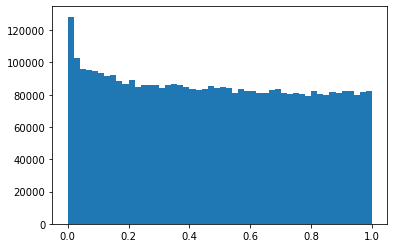

In [9]:
plt.hist(all_tests['corr_pval'], bins=50);

In [10]:
num_tests = all_tests.shape[0]

In [12]:
unif_quantiles = stats.uniform.ppf(np.linspace(0, 1, num_tests))

In [14]:
sorted_pvs = np.sort(all_tests.corr_pval)

In [13]:
unif_quantiles

array([0.00000000e+00, 2.33119904e-07, 4.66239809e-07, ...,
       9.99999534e-01, 9.99999767e-01, 1.00000000e+00])

/tmp/ipykernel_9752/1690487092.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs))


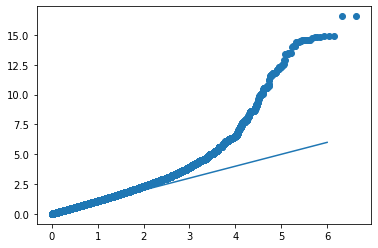

In [18]:
plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs))
plt.plot([0, 6], [0, 6], )

### Read coex eqtl results

In [7]:
cqtls = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}_coexpression.csv'.format(pop, ct))
        df['pop'] = pop
        df['ct'] = ct
        if df.query('corr_fdr < 0.1').shape[0] > 0:
            cqtls.append(df.query('corr_fdr < 0.1'))
            print(pop, ct, df.query('corr_fdr < 0.1')[['gene_1', 'gene_2']].drop_duplicates().shape[0])
cqtls = pd.concat(cqtls)

asian T4 6
asian cM 48
asian ncM 121
asian T8 18
eur cM 31
eur ncM 8
eur T8 5
eur B 23


In [8]:
cqtls[['gene_1', 'gene_2']].drop_duplicates().shape

(238, 2)

In [9]:
cqtls.to_csv(data_path + '../tables/Supplementary_Table_7_SLE_cQTL.csv', index=False)

In [10]:
cqtls[['gene_1', 'gene_2', 'tx']].drop_duplicates().shape

(3726, 3)

### Read eqtl results

In [11]:
eqtls = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}.csv'.format(pop, ct))\
			.query('FDR < 0.01 & (beta < -0.1 | beta > 0.1)')\
			.rename(columns={'gene':'gene_2', 'SNP':'tx'})[['tx', 'gene_2', 'beta']].copy()
        df['pop'] = pop
        df['ct'] = ct
        eqtls.append(df)
eqtls = pd.concat(eqtls)

### Merge the results

In [12]:
qtls = cqtls.merge(eqtls, on=['tx', 'gene_2', 'pop', 'ct'], how='left')

### Get ENCODE information

In [12]:
snp_locs = qtls.tx.drop_duplicates().tolist()

In [85]:
snp_site_windows = pd.DataFrame()
snp_site_windows['chrom'] = ['chr'+a.split(':')[0] for a in snp_locs]
snp_site_windows['txStart'] = [int(a.split(':')[1])-1 for a in snp_locs]
snp_site_windows['txEnd'] = [int(a.split(':')[1])+1 for a in snp_locs]
snp_site_windows['name'] = snp_locs

In [86]:
tfs = qtls['gene_1'].drop_duplicates().tolist()

In [87]:
encode_meta = pd.read_csv('../../cd4_cropseq/encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('../../cd4_cropseq/encode_tf/files.txt', sep='\t', header=None)

encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False).drop_duplicates('target').query('target in @tfs')
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull()]

In [ ]:
imp.reload(encode)
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')
encode_result = {}

for idx, row in encode_meta.iterrows():
    
    url = row['File download URL']
    genes = enc.get_peak_sites_encode(url, snp_site_windows)
    encode_result[row['target']] = genes.query('distance >= 0').copy()

In [89]:
encode_df = []
for k, v in encode_result.items():
    
    v['tf'] = k
    encode_df.append(v)
encode_df = pd.concat(encode_df)
encode_df.columns=['tx', 'distance', 'gene_1']
encode_df.to_csv(data_path + 'encode_result.csv', index=False)

### Merge ENCODE informatoin

In [13]:
encode_df = pd.read_csv(data_path + 'encode_result.csv')

In [14]:
qtls = qtls.merge(encode_df, on=['tx', 'gene_1'], how='left')#.sort_values('distance')

In [17]:
qtls.query('gene_1 == "JUNB" & gene_2 == "LYZ" & tx == "12:69688073"')

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr,statistic,pop,ct,beta,distance
581,JUNB,LYZ,12:69688073,-0.082832,0.014948,3.021250e-08,0.000071,-5.541405,asian,cM,-0.215241,934.0


### Plot some QTLs

In [13]:
cqtl_pairs = list(set([(a,b) for a,b in zip(qtls['gene_1'], qtls['gene_2'])]))
all_pair_genes = list(set(qtls['gene_1']) | set(qtls['gene_2']))

In [14]:
def get_expr(condition, gene):
    
    return np.log(adata[condition, gene].X.todense().A1+1)

In [ ]:
for pop in ['asian', 'eur']:
    
    pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        
        print(pop, ct)
        
        adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
        donor_counts = adata.obs['ind_cov'].value_counts()
        filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
        adata = adata[filter_condition].copy()
        adata.obs['capture_rate'] = 0.1
        memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)
        memento.create_groups(adata, label_columns=['ind_cov'])

        memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=all_pair_genes)
        memento.compute_2d_moments(adata, [(a,b) for a,b in cqtl_pairs if a in adata.var.index and b in adata.var.index])
        
        moments = memento.get_2d_moments(adata)[0].set_index(['gene_1', 'gene_2'])
        moments.columns = [x[3:] for x in moments.columns]
        
        to_plot = qtls.query('distance <1000 & (corr_coef*beta)>0 & ct == "{}" & pop == "{}"'.format(ct, pop))
        
        if to_plot.shape[0] == 0:
            continue
        
        for idx, row in to_plot.iterrows():
    
            gene_1, gene_2, SNP = row['gene_1'], row['gene_2'], row['tx']
            
            info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
            info.columns=[SNP, 'coexpression']
            info = info.query('coexpression < 1 & coexpression > -1')

            plt.figure(figsize=(10,3))
            plt.subplot(1,4,1)
            sns.boxplot(x=SNP, y='coexpression', data=info)
            sns.stripplot(x=SNP, y='coexpression', data=info)

            new_obs = adata.obs.merge(
                info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
                on='ind_cov', how='left')
            new_obs.index=adata.obs.index

            plt.subplot(1,4,2)
            plt.scatter(
                get_expr(new_obs['geno'] == 0, gene_1), 
                get_expr(new_obs['geno'] == 0, gene_2), s=1)

            plt.subplot(1,4,3)
            plt.scatter(
                get_expr(new_obs['geno'] == 1, gene_1), 
                get_expr(new_obs['geno'] == 1, gene_2), s=1)

            plt.subplot(1,4,4)
            plt.scatter(
                get_expr(new_obs['geno'] == 2, gene_1), 
                get_expr(new_obs['geno'] == 2, gene_2), s=1)
            plt.savefig('figures/{}_{}_{}_{}_{}.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches=False)

### Choose an example - JUND LYZ

In [39]:
SNP = '12:69688073'
gene_1 = 'JUNB'
gene_2 = 'LYZ'
pop = 'asian'
ct = 'cM'

In [5]:
pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

In [16]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
donor_counts = adata.obs['ind_cov'].value_counts()
filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
adata = adata[filter_condition].copy()
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)
memento.create_groups(adata, label_columns=['ind_cov'])

memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=all_pair_genes)
memento.compute_2d_moments(adata, [(a,b) for a,b in cqtl_pairs if a in adata.var.index and b in adata.var.index])

moments = memento.get_2d_moments(adata)[0].set_index(['gene_1', 'gene_2'])
moments.columns = [x[3:] for x in moments.columns]

In [18]:
adata.obs.head(5)

,batch_cov,ind_cov,Processing_Cohort,louvain,cg_cov,ct_cov,L3,ind_cov_batch_cov,Age,Sex,pop_cov,Status,SLE_status,capture_rate,memento_size_factor,memento_group
TGCGCAGAGCAATCTC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0,dmx_YS-JY-21_pool2,HC-519,4.0,0,cM,NaN,1.0,HC-519:dmx_YS-JY-21_pool2,21.0,Female,Asian,Healthy,Healthy,0.1,0.712631,sg^HC-519
TCGCGAGTCGCCAGCA-1-1-0-0-0-0-0-0-0-0-0-1,dmx_flare2,1791_1791,3.0,0,cM,NaN,0.0,1791_1791:dmx_flare2,66.0,Female,Asian,Managed,SLE,0.1,0.841502,sg^1791_1791
TCGGGACAGATGCCAG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,dmx_YE_7-26,1240_1240,2.0,7,cM,NaN,0.0,1240_1240:dmx_YE_7-26,23.0,Female,Asian,Managed,SLE,0.1,1.152943,sg^1240_1240
CATATTCAGTGTTAGA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0,dmx_YS-JY-22_pool5,HC-022,4.0,0,cM,NaN,1.0,HC-022:dmx_YS-JY-22_pool5,74.0,Female,Asian,Healthy,Healthy,0.1,0.551541,sg^HC-022
ACTGAACAGTTAACGA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0,dmx_YE_8-23,1771_1771,2.0,7,cM,NaN,0.0,1771_1771:dmx_YE_8-23,49.0,Female,Asian,Managed,SLE,0.1,0.704960,sg^1771_1771


In [20]:
def get_expr_one_person(condition, gene1, gene2):
    
    lucky_person = np.random.choice(adata[condition].obs.ind_cov.drop_duplicates())
    return np.log(adata[adata.obs.ind_cov==lucky_person, gene1].X.todense().A1+1), np.log(adata[adata.obs.ind_cov==lucky_person, gene2].X.todense().A1+1)

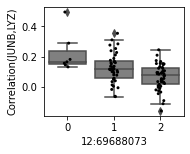

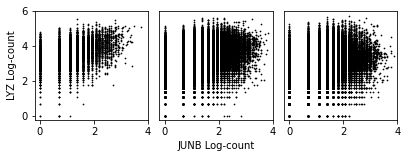

In [17]:
info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
info.columns=[SNP, 'coexpression']
info = info.query('coexpression < 1 & coexpression > -1')

plt.figure(figsize=(2.5,2))

sns.boxplot(x=SNP, y='coexpression', data=info, color='gray')
sns.stripplot(x=SNP, y='coexpression', data=info, color='black', s=3)
plt.ylabel('Correlation({},{})'.format(gene_1, gene_2))

plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

new_obs = adata.obs.merge(
    info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
    on='ind_cov', how='left')
new_obs.index=adata.obs.index

plt.figure(figsize=(6.5,2))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,3,1)
plt.scatter(
    get_expr(new_obs['geno'] == 0, gene_1), 
    get_expr(new_obs['geno'] == 0, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.ylabel('{} Log-count'.format(gene_2))

plt.subplot(1,3,2)
plt.scatter(
    get_expr(new_obs['geno'] == 1, gene_1), 
    get_expr(new_obs['geno'] == 1, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 4)
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.xlabel('{} Log-count'.format(gene_1))
plt.yticks([])

plt.subplot(1,3,3)
plt.scatter(
    get_expr(new_obs['geno'] == 2, gene_1), 
    get_expr(new_obs['geno'] == 2, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 4)
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.yticks([])



plt.savefig('{}_{}_{}_{}_{}_scatter.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight', dpi=300)

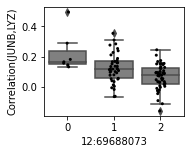

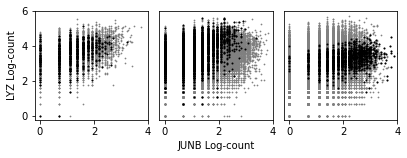

In [44]:
info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
info.columns=[SNP, 'coexpression']
info = info.query('coexpression < 1 & coexpression > -1')

plt.figure(figsize=(2.5,2))

sns.boxplot(x=SNP, y='coexpression', data=info, color='gray')
sns.stripplot(x=SNP, y='coexpression', data=info, color='black', s=3)
plt.ylabel('Correlation({},{})'.format(gene_1, gene_2))

# plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

new_obs = adata.obs.merge(
    info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
    on='ind_cov', how='left')
new_obs.index=adata.obs.index

plt.figure(figsize=(6.5,2))

vals11, vals12 = get_expr_one_person(new_obs['geno'] == 0, gene_1, gene_2)
vals21, vals22 = get_expr_one_person(new_obs['geno'] == 1, gene_1, gene_2)
vals31, vals32 = get_expr_one_person(new_obs['geno'] == 2, gene_1, gene_2)
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,3,1)
plt.scatter(
    get_expr(new_obs['geno'] == 0, gene_1), 
    get_expr(new_obs['geno'] == 0, gene_2), s=0.5, color='grey')
plt.scatter(
    vals11, 
    vals12, s=1, color='black')
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.ylabel('{} Log-count'.format(gene_2))

plt.subplot(1,3,2)
plt.scatter(
    get_expr(new_obs['geno'] == 1, gene_1), 
    get_expr(new_obs['geno'] == 1, gene_2), s=0.5, color='grey')
plt.scatter(
    vals21, 
    vals22, s=1, color='black')
plt.xlim(-0.2, 4)
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.xlabel('{} Log-count'.format(gene_1))
plt.yticks([])

plt.subplot(1,3,3)
plt.scatter(
    get_expr(new_obs['geno'] == 2, gene_1), 
    get_expr(new_obs['geno'] == 2, gene_2), s=0.5, color='grey')
plt.scatter(
    vals31, 
    vals32, s=1, color='black')
plt.xlim(-0.2, 4)
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.yticks([])



plt.savefig('{}_{}_{}_{}_{}_scatter_individual_1.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight', dpi=300)

### Choose an example - CEPBD LYZ

In [99]:
SNP = '12:69740869'
gene_1 = 'CEBPD'
gene_2 = 'LYZ'
pop = 'asian'
ct = 'cM'

In [100]:
pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

In [101]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
donor_counts = adata.obs['ind_cov'].value_counts()
filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
adata = adata[filter_condition].copy()
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)
memento.create_groups(adata, label_columns=['ind_cov'])

memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=all_pair_genes)
memento.compute_2d_moments(adata, [(a,b) for a,b in cqtl_pairs if a in adata.var.index and b in adata.var.index])

moments = memento.get_2d_moments(adata)[0].set_index(['gene_1', 'gene_2'])
moments.columns = [x[3:] for x in moments.columns]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


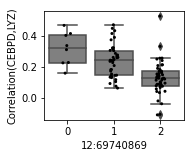

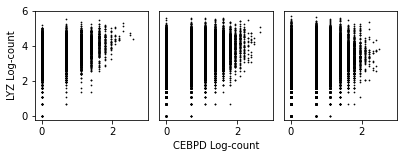

In [102]:
info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
info.columns=[SNP, 'coexpression']
info = info.query('coexpression < 1 & coexpression > -1')

plt.figure(figsize=(2.5,2))

sns.boxplot(x=SNP, y='coexpression', data=info, color='gray')
sns.stripplot(x=SNP, y='coexpression', data=info, color='black', s=3)
plt.ylabel('Correlation({},{})'.format(gene_1, gene_2))

plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

new_obs = adata.obs.merge(
    info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
    on='ind_cov', how='left')
new_obs.index=adata.obs.index

plt.figure(figsize=(6.5,2))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,3,1)
plt.scatter(
    get_expr(new_obs['geno'] == 0, gene_1), 
    get_expr(new_obs['geno'] == 0, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 3); plt.ylim(-0.2, 6)
plt.ylabel('{} Log-count'.format(gene_2))

plt.subplot(1,3,2)
plt.scatter(
    get_expr(new_obs['geno'] == 1, gene_1), 
    get_expr(new_obs['geno'] == 1, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 3); plt.ylim(-0.2, 6)
plt.xlabel('{} Log-count'.format(gene_1))
plt.yticks([])

plt.subplot(1,3,3)
plt.scatter(
    get_expr(new_obs['geno'] == 2, gene_1), 
    get_expr(new_obs['geno'] == 2, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 3); plt.ylim(-0.2, 6)
plt.yticks([])
plt.savefig('{}_{}_{}_{}_{}_scatter.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight', dpi=300)

In [103]:
to_plot = qtls.query('distance ==0 & (corr_coef*beta)>0')

In [104]:
to_plot

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr,statistic,pop,ct,beta,distance
850,SPI1,TMEM176B,7:150435443,0.147797,0.037970,0.000103,0.050430,3.892474,asian,cM,0.158933,0.0
1653,DRAP1,CD52,1:26698430,-0.164368,0.033612,0.000003,0.015824,-4.890130,asian,ncM,-0.265891,0.0
1678,DRAP1,CD52,1:26695758,-0.166921,0.033718,0.000003,0.013925,-4.950500,asian,ncM,-0.256660,0.0
2371,XRCC5,TMEM176B,7:150448873,0.722535,0.117389,0.000073,0.076932,6.155075,asian,ncM,0.250768,0.0


### Check LYZ for trans eQTL

In [5]:
SNP = '12:69688073'
gene_1 = 'JUNB'
gene_2 = 'LYZ'
pop = 'asian'
ct = 'cM'

In [6]:
data_path  = '/data_volume/memento/lupus/'

# Read genetics data
pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)
cov = pd.read_csv(data_path + 'mateqtl_input/{}_mateqtl_cov.txt'.format(pop), sep='\t', index_col=0).T

# Read encode data to filter TFs
encode_meta = pd.read_csv('../../cd4_cropseq/encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('../../cd4_cropseq/encode_tf/files.txt', sep='\t', header=None)
encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False)
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull() & encode_meta['Audit NOT_COMPLIANT'].isnull()]
encode_tfs = encode_meta.target.tolist()

In [23]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
donor_counts = adata.obs['ind_cov'].value_counts()
filter_condition = adata.obs.ind_cov.isin(pos.columns)
adata = adata[filter_condition].copy()
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01, estimator_type='mean_only')
memento.create_groups(adata, label_columns=['ind_cov'])

cov_df = cov.loc[[x[3:] for x in adata.uns['memento']['groups']]]
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [24]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=['JUNB', 'CEBPD'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [25]:
memento.ht_1d_moments(
    adata, 
    covariate=cov_df,
    treatment=donor_df,
    treatment_for_gene={'JUNB':['12:69688073'], 'CEBPD':['12:69740869']},
    num_boot=5000, 
    verbose=1,
    num_cpus=1,
    resampling='bootstrap',
    approx=False,
    resample_rep=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s finished


In [29]:
memento_result = memento.get_1d_ht_result(adata)

In [30]:
memento_result

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,CEBPD,12:69740869,0.004680,0.015455,0.7594,0.0,3.191600e-16,1.0
0,JUNB,12:69688073,0.001669,0.016975,0.9206,0.0,3.674161e-16,1.0
